In [1]:
# imports libraries
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import time
from datetime import datetime

# Lines below are just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
# read dataset and show the first 5 rows
df = pd.read_csv('../dataset/full_COA.csv.' , index_col='Time',parse_dates=True)
df.head()

,COA,temp,year,quarter,month,day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,
2012-01-01 01:00:00,5986.0,13.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 02:00:00,5547.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 03:00:00,5233.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 04:00:00,5150.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 05:00:00,5235.0,11.98,2012,1,1,1,0,0,0,0,0,0,1


In [3]:
# show last five rows
df.tail()

,COA,temp,year,quarter,month,day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,
2017-12-31 19:00:00,9495.0,18.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 20:00:00,9365.0,16.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 21:00:00,9250.0,15.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 22:00:00,8931.0,14.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 23:00:00,8679.0,12.98,2017,4,12,31,0,0,0,0,0,0,1


In [4]:
# get only megawaats and tempreture
df_l = df[['COA','temp']]

In [5]:
# show length of dataframe
len(df_l)

52607

In [6]:
# assain frequebcy to hourly
df_l.index.freq = '1H'

In [7]:
# resample data to monthly data
df_m = df_l.resample(rule = 'MS').mean()

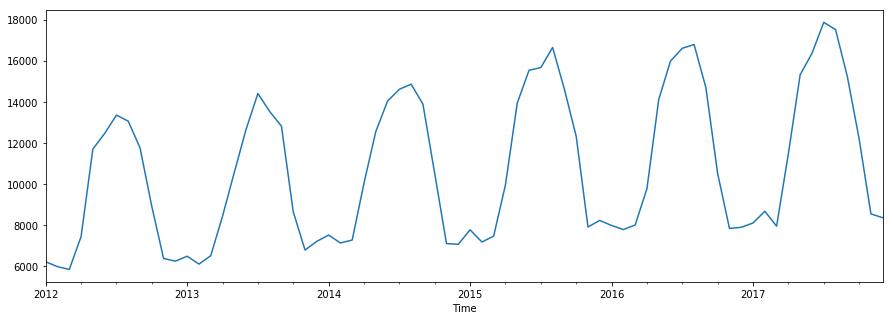

In [8]:
# plotting daily data set
pd.plotting.register_matplotlib_converters() # this code used to resolve some failure prophet have with pandas
df_m.COA.plot(figsize=(15,5)).autoscale(axis='x',tight=True)

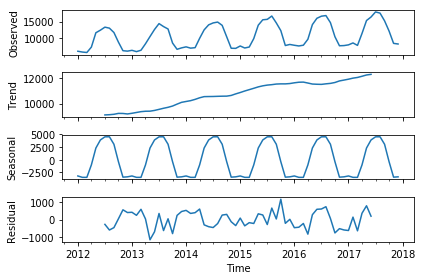

In [10]:
# seasonal decompose for megawatts 
seasonal_decompose(df_m.COA).plot();

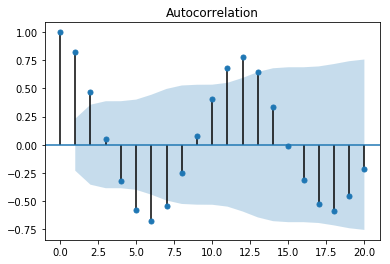

In [11]:
# autocorrelation plot
plot_acf(df_m.COA , lags=20);

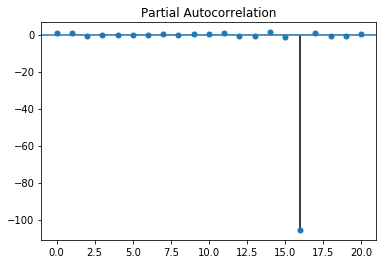

In [12]:
# partial autocorrelaton plot
plot_pacf(df_m.COA , lags=20);

In [13]:
# define a function to do the Dickey-Fuller Test

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [14]:
# Dickey-Fuller Test for megawatts
adf_test(df_m.COA)

Augmented Dickey-Fuller Test: 
ADF test statistic      -0.391346
p-value                  0.911534
# lags used             11.000000
# observations          60.000000
critical value (1%)     -3.544369
critical value (5%)     -2.911073
critical value (10%)    -2.593190
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [15]:
# reset index to prepare data frame for prophet
df_m = df_m.reset_index()

In [17]:
# feature engineering 
df_m['year'] = df_m['Time'].apply(lambda x: x.year)
df_m['quarter'] = df_m['Time'].apply(lambda x: x.quarter)
df_m['month'] = df_m['Time'].apply(lambda x: x.month)
df_m['day'] = df_m['Time'].apply(lambda x: x.day)
df_m["weekday"]=df_m.apply(lambda row: row["Time"].weekday(),axis=1)
df_m["weekday"] = df_m["weekday"].astype(str)
df_m = pd.get_dummies(df_m)

In [18]:
# rename columns to prepare it for prophet
df_m = df_m.rename(columns = {'Time':'ds',
                      'COA':'y'})

In [19]:
# define a length to split, split last year
l_split = len(df_m[df_m.ds >= '2017-01-01 00:00:00'])

In [20]:
# split by pre defined length
train = df_m.iloc[:(len(df_m)-l_split)]
test = df_m.iloc[(len(df_m)-l_split):]

In [21]:
# fitting the model with additional regressors
model = Prophet()
model.add_regressor('temp')
model.add_regressor('year')
model.add_regressor('quarter')
model.add_regressor('month')
model.add_regressor('day')
model.add_regressor('weekday_0')
model.add_regressor('weekday_1')
model.add_regressor('weekday_2')
model.add_regressor('weekday_3')
model.add_regressor('weekday_4')
model.add_regressor('weekday_5')
model.add_regressor('weekday_6')
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
# make data frame to hold the prediction
future = model.make_future_dataframe(periods=12 , freq='MS')

In [23]:
# make prediction on the data frame made 
forecast = model.predict(test.drop(columns="y"))

In [24]:
# check predictionn columns
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'day',
       'day_lower', 'day_upper', 'extra_regressors_additive',
       'extra_regressors_additive_lower', 'extra_regressors_additive_upper',
       'month', 'month_lower', 'month_upper', 'quarter', 'quarter_lower',
       'quarter_upper', 'temp', 'temp_lower', 'temp_upper', 'weekday_0',
       'weekday_0_lower', 'weekday_0_upper', 'weekday_1', 'weekday_1_lower',
       'weekday_1_upper', 'weekday_2', 'weekday_2_lower', 'weekday_2_upper',
       'weekday_3', 'weekday_3_lower', 'weekday_3_upper', 'weekday_4',
       'weekday_4_lower', 'weekday_4_upper', 'weekday_5', 'weekday_5_lower',
       'weekday_5_upper', 'weekday_6', 'weekday_6_lower', 'weekday_6_upper',
       'year', 'year_lower', 'year_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_

In [25]:
# show last 5 rows of forecast
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7,2017-08-01,-36913.788094,16198.456492,17223.025768,-36916.255464,-36911.502115,53639.857230,53639.857230,53639.857230,20747.648809,...,24473.276866,24473.276866,24473.276866,-3086.275436,-3086.275436,-3086.275436,0.0,0.0,0.0,16726.069136
8,2017-09-01,-37556.072950,14749.558348,15823.813014,-37558.998643,-37553.343650,52839.613842,52839.613842,52839.613842,20747.648809,...,24473.276866,24473.276866,24473.276866,6249.811296,6249.811296,6249.811296,0.0,0.0,0.0,15283.540892
9,2017-10-01,-38177.638940,11627.211233,12650.654925,-38181.137885,-38174.558704,50313.798149,50313.798149,50313.798149,20747.648809,...,24473.276866,24473.276866,24473.276866,-25292.767579,-25292.767579,-25292.767579,0.0,0.0,0.0,12136.159210
10,2017-11-01,-38819.923796,8866.294546,9877.780718,-38824.013580,-38816.286157,48191.109741,48191.109741,48191.109741,20747.648809,...,24473.276866,24473.276866,24473.276866,-16287.783110,-16287.783110,-16287.783110,0.0,0.0,0.0,9371.185946
11,2017-12-01,-39441.489785,8245.265524,9258.928020,-39446.203860,-39437.348871,48180.422075,48180.422075,48180.422075,20747.648809,...,24473.276866,24473.276866,24473.276866,-5214.982970,-5214.982970,-5214.982970,0.0,0.0,0.0,8738.932290


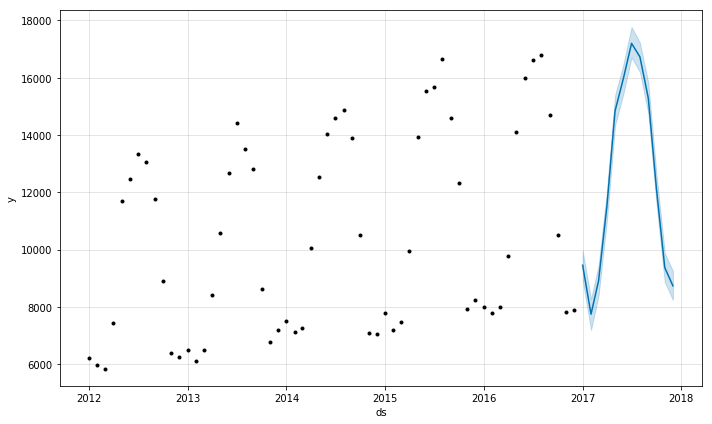

In [26]:
# plotting forcast
model.plot(forecast);

In [27]:
# make a seperate data set for prediction only
predictions = forecast[['ds','yhat']][forecast.ds >='2017']

In [28]:
# set time as index
predictions = predictions.set_index('ds')
test = test.set_index('ds')

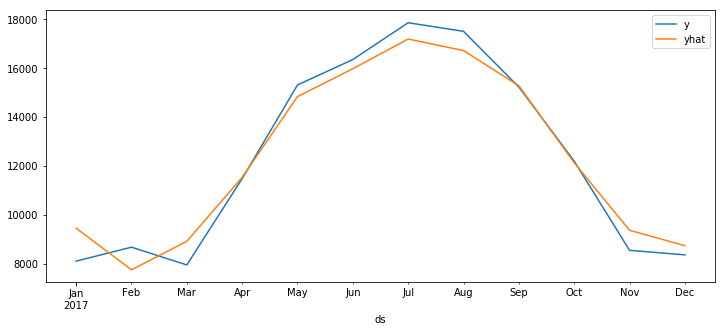

In [29]:
# plot test vs prediction
test.y.plot(legend=True)
predictions.yhat.plot(figsize=(12,5) , legend=True)

In [30]:
# calculate rmse
rmse(test.y,predictions.yhat)

699.7963728221572

In [31]:
# calculate r2 score
r2_score(test.y , predictions.yhat)

0.9658703367878109